# Dimensionality Reduction



<hr style="border:2px solid gray">

# Outline <a id='index'></a>
1. [Introduction to Dimensionality Reduction](#intro)
1. [Principal Component Analysis](#PCA)
1. [PCA in Action](#using_PCA)
1. [Choosing Number of Dimensions](#choosing_dim)
1. [More Complex DR](#more_complex)
1. [Appendices](#appendix)
    * [A: Singular Valued Decomposition (SVD)](#SVD_app)
    * [B: PCA, and its relation to SVD](#PCA_app)



_For extra information on dimension analysis, see [Stanford Slides](https://web.stanford.edu/class/cs246/slides/06-dim_red.pdf) and **{homl}**_

<hr style="border:2px solid gray">

# Introduction to Dimensionality Reduction [^](#index) <a id='intro'></a>

## Why should we use this?

So far, we have only examined datasets containing a relatively limited number of features - MNIST 'only' consisted of 784. However, it's common to encounter datasets with thousands or even millions of features. Models trained on datasets with many features are significantly slower compared to those built on datasets with only a few features (as we saw with MNIST vs Iris data). Reducing the number of dimensions should reduce this problem.

There are other reasons to use dimensionality reduction:

Even if you normalise all your data, adding more features will add more dimensions to the hyperspace that you need to fill and therefore characterise/model. Consider:

* If you pick two points at random from a unit square (i.e. a two-featured space), their separation on average is approximately 0.52. 
* When you go to a 3D cube, this value increases to approximately 0.66. 
* If you have a million features, this has grown to approximately *408.25*. 

This means that for many input features, your model is now training on very sparse data, which may not be representative.

The obvious answer is to use more data to train the model; however, you would need more data than there are atoms in the observable universe to have an average separation of 0.1 for just 100 dimensions. This is the **Curse of Dimensionality** (see [Wikipedia](https://en.wikipedia.org/wiki/Curse_of_dimensionality)).

However, in any dimensionality reduction some information will be lost, an effect we clearly want to minimise. 
A good way to achieve this is to try to retain the maximum variance in your reduced data set. That way you will (generally) loose the smallest amount of discrimination.

For example, consider two, highly correlated features. Keeping both features will provide minimal extra information to the training model, but will just have a higher number of dimensions. This would be a good example of a feature to remove (in reality we use slightly more complex techniques).


<hr style="border:2px solid gray">

# Principal Component Analysis (PCA) [^](#index) <a id='PCA'></a>

By far the most common type of dimensionality reduction is **Principal Component Analysis (PCA)**, and thus it is the only one that we will cover in detail. 

The basic idea of PCA is to linearly transform our data from its initial input feature space to some new, lower dimensional feature space where the new coordinates can explain the maximum amount of the variation in the data i.e. we maximise the variance in the new feature space.


## An Example of Vector Projection

In the code cells below, we define some data with two input features $X_1$ and $X_2$, and three possible new axes to describe the data for dimensionality reduction. 

In [1]:
# first some basics
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

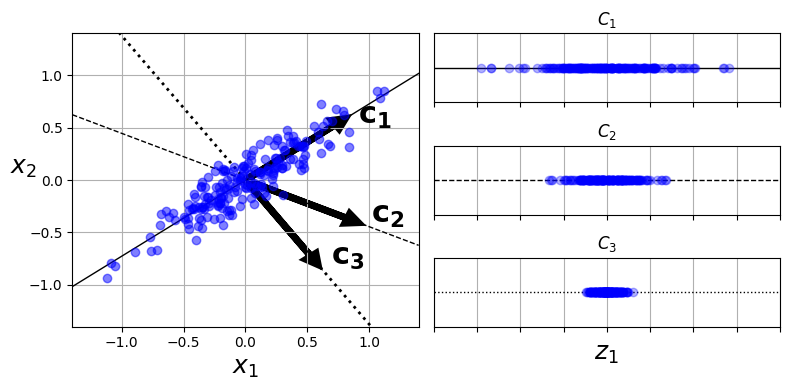

In [2]:
# Define constants for rotation and stretch
angle = np.pi / 5
stretch = 5
m = 200

# Set seed for reproducibility of random data
np.random.seed(3)

# Generate random 2D data and scale it down
X = np.random.randn(m, 2) / 10

# Stretch the data in the direction of the x-axis
X = X.dot(np.array([[stretch, 0],[0, 1]]))

# Rotate the data by the defined angle
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

# Define three unit vectors for projection in different directions
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

# Project the data onto these three vectors
X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))


plt.figure(figsize=(8,4))

# First subplot: original 2D data with the unit vectors
plt.subplot2grid((3,2), (0, 0), rowspan=3)
# Plot unit vectors and their respective lines
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)


plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])

# Plot arrows representing unit vectors
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u2[0], u2[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')


plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u2[0] + 0.1, u2[1], r"$\mathbf{c_2}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_3}$", fontsize=22)


plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)

plt.grid(True)

# Second, third, and fourth subplots: projections onto each unit vector
for idx, X_proj in enumerate([X_proj1, X_proj2, X_proj3], start=1):
    plt.subplot2grid((3,2), (idx-1, 1))
    plt.plot([-2, 2], [0, 0], "k-" if idx==1 else "k--" if idx==2 else "k:", linewidth=1)
    plt.plot(X_proj[:, 0], np.zeros(m), "bo", alpha=0.3)
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticklabels([])
    plt.axis([-2, 2, -1, 1])
    plt.title('$C_{{{}}}$'.format(idx))
    plt.grid(True)

# Add x-axis label to the last subplot
plt.xlabel("$z_1$", fontsize=18)
plt.tight_layout()
plt.show()


This plot shows how we think about PCA; the plot on the left shows the original data as a scatter plot, as well as three possible components. If we were to perform PCA using these components, we would select $C_1$ as our first principle component as the greatest variance of the data is along this line (after we "flatten" all the data onto that line). The second principle component chosen would be $C_3$ as it is our next highest variance component *while still being perpendicular to* $C_1$. All of our principle components *must* be perpendicular to one another, like any coordinate axes.


To find these vectors, we typcially use **Singular Value Decomposition** (SVD), a well known linear algebra technique which factorises matrices. 

Numpy has a function which will return these, although the input must be centered around zero.

In [3]:
X_centered = X-X.mean(axis=0)

U,s, Vh=np.linalg.svd(X_centered) # docs at https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
c1=Vh.T[:,0]
c2=Vh.T[:,1]

<div style="background-color: #FFF8C6">
    
## Singular Value Decomposition (SVD) <a id='svd'></a>
    
The SVD of an $m \times n$ matrix $A$ is its factorisation into the product of three matrices:
\begin{equation}  
    A = UDV^T,
\end{equation}
where $A$ is the matrix containing our data.
    
$U$ is the $m \times m$ matrix of the orthonormal eigenvectors of $AA^T$. These eigenvectors are denoted by $u_i$.
    
$V^T$ is the transpose of an $m \times n$ matrix containing the orthonormal eigenvectors of $A^TA$. Similarly, these eigenvectors are denoted by $v_i$.
    
$D$ is an $m \times n$ "diagonal matrix" (i.e. only elements which have position $i = j$ are non-zero) with $r$ elements - each equal to the square root of the positive eigenvalues of $AA^T$ (or $A^TA$, since the positive eigenvalues will be the same). We will refer to the elements of this matrix as $\sigma_i$, so the values $\sigma_i^2$ are the eigenvalues of the matrix $AA^T$.
    
## Principal Component Analysis (PCA) <a id='pca_description'></a>
    
The 'principal components' are the vectors that maximise the variance of the data points projected in their direction. These vectors are the **eigenvectors** of the **covariance matrix** of the data which have the **greatest eigenvalues**.

After identifying the principal components, you can project the data onto a hyperplane of dimension $d$ that is defined by the initial $d$ principal components. This process is designed to minimize the loss of data variance.
    
The mathematics involved in making this statement, and the relationship between PCA and SVD, are too detailed to be written here. Please read Appendix B: [PCA, and its relation to SVD](#pca_app) for more information.

# PCA in Action [^](#index) <a id='using_PCA'></a>

Let's return to our old friend MNIST to see PCA in action. First we will load in the data, and have PCA transform our data down to 200 dimensions.

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
print(mnist.keys())

/home/collngdj/.conda/envs/ML_env_min/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


As always, we will split our data into test and training datasets.

In [5]:
X=mnist['data']
y=mnist['target']

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Now that we have our data, we can try applying PCA; here, the argument `n_components` tells us how many features we will reduce to. In this case, we have chosen 200, in contrast to the 784 features in the original data.

In [6]:
from sklearn.decomposition import PCA

pca=PCA(n_components=200) # choose the first 200 components out 784
X_reduced=pca.fit_transform(X_train)

We will do some quick checks that things make sense, i.e. the number of components in the PCA object, and the shape of `X_reduced`.

In [7]:
print(pca.components_.shape)
print(X_reduced.shape)

(200, 784)
(60000, 200)


As you can see, we have 200 vectors in 784 dimensions for our PCA components, which makes sense as we are selecting our first 200 principle components. Similarly, while originally `X_train` had the shape (60000, 784) i.e. 60000 samples and 784 features, `X_reduced` has shape (60000, 200) i.e. 60000 samples with only 200 features, as we would expect. Clearly we have quickly found some new lower dimensional feature space we can try representing our data in. We will see later how this has affected how our data looks.

# Choosing Number of Dimensions [^](#index) <a id='choosing_dim'></a>


## Explained Variance Ratio 

The explained variance ratio indicates the proportion of the dataset's variance that lies along each principal component. This lets us see how much of our variance we lose when we select our principle components. For example, using just the first 10 principle components in MNIST leads to a variance loss of around 50%.

In [9]:
ten_array= pca.explained_variance_ratio_[0:10]
print("lost=",1-ten_array.sum())

lost= 0.51185019645066


Rather than plucking a number out of a hat, you could decide how much variance you wish to retain and use this to decide the dimensionality that you want to use. You could do this for an increasing number of dimensions and then see which is the first above your threshold. In this case, we aim to retain at least 95% of our variance. 

In [10]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 
# the argmax term will return the index of the first element which satisfies our condition
print(d)

154


Sklearn can also do this for you. Rather than n_components being equal to a number of principal components, n_components can instead be the variance ratio that you want to keep (a number between 0 and 1). 

In [11]:
pca=PCA(n_components=0.95)
X_reduced=pca.fit_transform(X_train)
pca.n_components_

154

You could also plot the explained variance as a function of the number of dimensions. We can label the elbow of this curve to find the number of principle components after which the increase in variance is less than proportional to the increase in number of principle components. 

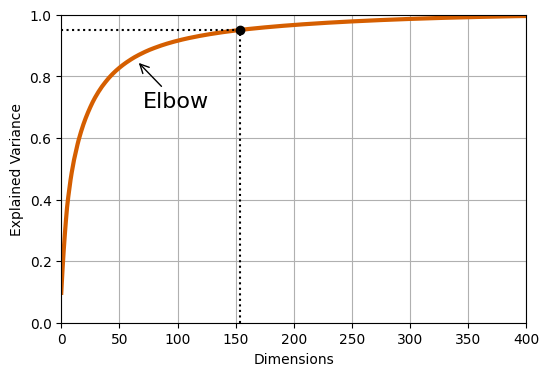

In [25]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3,color='#D55E00')
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

The value of 154 means that you only need to store $\approx$ 20% of the data for 95% of the information - this means you can use PCA as a form of compression. 

In the code cell below, we define a function to plot some of the digits. We will compare how the digits look before we apply PCA, or after we have applied PCA and used the inverse transform to try to get back our data. We see that we have lost some resolution, which is because we have lost some of the data variance in the PCA process.

In [13]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [14]:
pca = PCA(n_components = 154) 

X_reduced = pca.fit_transform(X_train)


X_recovered = pca.inverse_transform(X_reduced)

In [15]:
X_reduced.shape

(60000, 154)

Text(0.5, 1.0, 'Compressed')

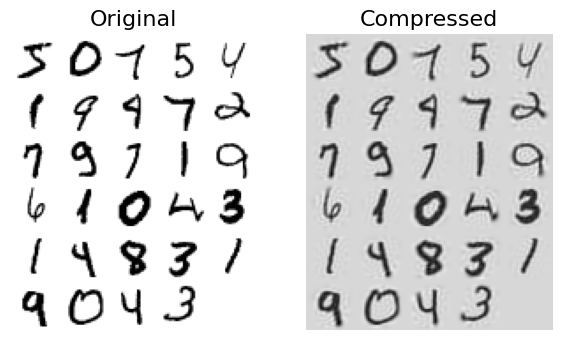

In [16]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

<div style="background-color:#C2F5DD">

### Exercise 

Try varying the number of dimensions and see what difference it makes to the the image. Start with a very low number of principle components and build up.

In [ ]:
# Your code here


<div style="background-color:#C2F5DD">

### Exercise

Use your favourite classifier (e.g. SVC or BDT) to classify the MNIST data set as well as you can. Then see how the timing and accuracy changes if you use versions with reduced dimensions and plot your results (for example: accuracy against number of dimensions). 

[SVC: Support Vector Classification; BDT: Boosted Decision Trees]

In [ ]:
# Your code here


<hr style="border:2px solid gray">


# More Complex Dimensionality Reduction [^](#index) <a id='more_complex'></a>

## Variants of PCA

You should be aware that there exists variants of PCA that can be useful, although they are beyond the scope of this course. These include:
* **Kernel PCA** where you use a similar kernel trick as with SVMs to introduce nonlinear features (without really doing so).
* Randomised PCA that generates good approximations to the principle components in a semi-random way and is a lot faster for large feature sets.


## Other forms of dimensionality reduction

There exist many other forms of dimensionality reduction, but none anywhere near as popular as PCA. These include: Locally Linear Embedding, Random Projections, Linear Discriminant Analysis, and more. They all have their place and you should know that there are more out there that exist, but knowledge beyond that is not required for this course.

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# Appendix <a id='appendix'></a>

[Return to Index](#index)

In this section, you will find longer pieces of mathematics and code which are **non-examinable**. Please read at your own discretion.

- A. [Singular Valued Decomposition (SVD)](#svd_app)
- B. [PCA, and its relation to SVD](#pca_app)


<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## Singular Value Decomposition - Detailed Mathematics [^](#appendix) <a id='svd_app'></a>
    
[Return to SVD section of notes](#svd)

Recap - The fundamental SVD equation is given by:
\begin{equation*}  
    A = UDV^T
\end{equation*}

When applying SVD to PCA, $A$ is the matrix containing our centred data (i.e. the original data - mean of the data). Let $\mathbf {x_i}$ be a column vector containing the data for a particular feature, so that $A$ = [ $\mathbf{x_1, x_2, ..., x_k}$ ] - to clarify, each row is a different sample, each column is a different feature. 
    
$U$ is the $m \times m$ matrix of the orthonormal eigenvectors of $AA^T$. These eigenvectors are denoted by $u_i$ and are sometimes called the **left singular vectors.**
    
$V^T$ is the **transpose** of an $n \times n$ matrix containing the orthonormal eigenvectors of $A^TA$. Similarly, these eigenvectors are denoted by $v_i$, and are called the **right singular vectors**.
    
$D$ is an $m \times n$ "diagonal matrix" (i.e. only elements which have position $i = j$ are non-zero) with **r** elements - each equal to the root of the positive eigenvalues of $AA^T$ (or $A^TA$, since the positive eigenvalues will be the same). We will refer to the elements of this matrix as the **singular values**, $\sigma_i$.
    
An important identity relation to note is:
\begin{align*}     
    U^TU &= I \\ 
    V^TV &= I 
\end{align*}    
This can be derived from the definition of orthonormal eigenvectors and their inner products.

<div style="background-color:#efdff2">
    
$AA^T$ and $A^TA$ are matrices with special properties:
- They are symmetric, square matrices
    - This is useful, since we can therefore choose the eigenvectors to be orthonormal (this is a fundamental property of symmetric matrices)
- The eigenvalues of both matrices are either positive or 0, and the matrices share the same positive eigenvalues
    - (Since the eigenvalues can be zero, the matrices do not necessarily have the same _number_ of eigenvalues).
    
Note that while $AA^T$ and $A^TA$ are symmetric, $A$ itself is not. 

<div style="background-color:#efdff2">
    
### Proof of the Fundamental SVD Formula
    
    
Suppose we are trying to find the form of the matrices in the decomposition:
\begin{equation*}  
    A = UDV^T
\end{equation*}

We will also assume $U$ and $V$ obey the identity relation $U^TU = V^TV = I$.

Transposing both sides (and since $D$ is diagonal, $D^T = D$):
    
\begin{equation*}  
    A^T = VDU^T
\end{equation*}

Combining, we get:
\begin{align*}  
    A^TA &= (VDU^T)(UDV^T) = VD^2V^T \\
    A^TAV &= VD^2
\end{align*}  
    
This is the eigenvalue equation for $A^TA$. To demonstrate this, consider a single column of $V$, which we will denote as $\mathbf{v}_i$. 
    
\begin{equation*}  
    A^TA \mathbf{v}_i = \mathbf{v}_i D^2
\end{equation*}

We know $D$ is a diagonal matrix with diagonal elements $\sigma_i$, so $D^2$ is a diagonal matrix with diagonal elements $\sigma_i^2$. We can therefore write this equation as

\begin{equation*}
A^TA \mathbf{v}_i = \sigma_i^2 \mathbf{v}_i
\end{equation*}

We can therefore see that $v_i$ is an eigenvector of $A^TA$, with eigenvalue $\sigma_i^2$. 
    
We can perform a similar derivation for $U$ to show that each column $\mathbf{u}_i$ of $U$ is an eigenvector of $AA^T$ with eigenvalue $\sigma_i^2$. 

<div style="background-color:#efdff2">
    
### Practical Considerations
    
The eigenvectors in $U$ and $V$ can be written in any order for the logic to apply. However, by convention, the eigenvectors are arranged such that their corresponding eigenvalues are in descending order. 
    
When we have a symmetric matrix $A$ (i.e. $A^TA = AA^T$) we can encounter issues with determining $U$ and $V$. To obtain unique eigenvectors, we must first multiply from the right by $V$:
    
\begin{align*}
    A &= UDV^T \\
    AV &= UDV^T V \\
    AV &= U D \\
\end{align*}   

If we consider a single column of $U$, we know that 

\begin{equation*}
AV_i = \mathbf{u}_i \sigma_i,
\end{equation*}
where $AV_i$ is the $i$-th column of the product $AV$. 

As a result, we can determine the matrix $U$ from the product $AV$ by dividing by the elements of our diagonal matrix $D$:

\begin{equation*}
\mathbf{u}_i = \frac{AV_i}{\sigma_i}
\end{equation*}
      
Let us run through an example. First we will define our necessary functions to find the matrices:

In [17]:
def find_V_t(A):
    A_t=A.transpose()
    M=np.matmul(A_t, A)
    
    #Find the eigenvalues and normalised eigenvectors of the multiplied matrix in ascending order
    e_val, e_vec = np.linalg.eigh(M)
    
    e_val=e_val[::-1] # Invert the order to get in descending order of eigenvalues
    
    for num, vec in enumerate(e_vec): # get eigenvectors in same order as eigenvalues
        e_vec[num]=vec[::-1]
 
    e_vec_t=e_vec.transpose()
    
    return e_val, e_vec_t

In [18]:
def find_D(A, e_val):
    empty_M=np.zeros(np.shape(A))
    count=0

    for val in e_val:
        if np.round(val, 5) <=0 : 
            # To remove 0 values, which may not be calculated as exactly 0 due to float point error
            continue

        empty_M[count, count]=np.sqrt(val)
        count+=1

    return empty_M

In [19]:
def find_U(A, V_t, D):
    
    V=V_t.transpose()
    D_inverse= np.linalg.pinv(D)
    #The pseudoinverse means that an 'inverse' can still be calculated if D is singular
    M1 = np.matmul(A,V) 
    U = np.matmul(M1, D_inverse) # Multiplying by D inverse is same as dividing each row by sigma_i
    return U   

<div style="background-color:#efdff2">
    
We might also want to define a function to check that our calculated value of U does indeed contain the correct eigenvectors:

In [20]:
def check_U(A, U):
    check=True
    A_t = A.transpose()
    M = np.matmul(A, A_t)
    
    #Find the eigenvalues and normalised eigenvectors of the multiplied matrix in ascending order
    _, U_guess = np.linalg.eigh(M)
    
    for num, vec in enumerate(U_guess):
        U_guess[num]=vec[::-1]
    
    U_guess_t= U_guess.transpose() # to make it easier to access the eigenvalues
    U_t = U.transpose()
    
    for i, j in zip(U_guess_t, U_t):

        for index in range(0, len(i)):
            i[index]=np.round(i[index], 10)
            j[index]=np.round(j[index], 10) # to remove float point errors
        

        if np.array_equal(i,j) or np.array_equal(i,-j): 
            #checks if two arrays have the same values
            continue
            
        check=False
        
    return check

<div style="background-color:#efdff2">
    
Now let us perform an example with a 3x2 matrix

In [21]:
A= np.array([[ 3., 2.,  2.],
             [ 2.,  3., -2.]])

In [22]:
def our_SVD(A, check=False):
    e_val, V_t = find_V_t(A)
    D= find_D(A, e_val)
    U= find_U(A,V_t, D)
    if check:
        print ('Does U match our prediction?: ',check_U(A, U))
    return (U, D, V_t)

In [23]:
U, D, V_t =our_SVD(A, check=True)

#Checking to see if we do indeed get A:

M_1=np.matmul(U,D)
M=np.matmul(M_1, V_t)
print (M)

Does U match our prediction?:  True
[[ 3.  2.  2.]
 [ 2.  3. -2.]]


<div style="background-color:#efdff2">

It may be useful to visualise the effect of each constituent factor of $A$ on some data, i.e. how they work as a coordinate transform. We will switch to a 2x2 matrix to make the visualisation easier.
    
We first act on our data with $V^T$, which acts as a rotation matrix. $D$ acts as a stretch matrix, and finally $U$ acts as another rotation matrix. The final result is the action of the composite matrix $A$. 


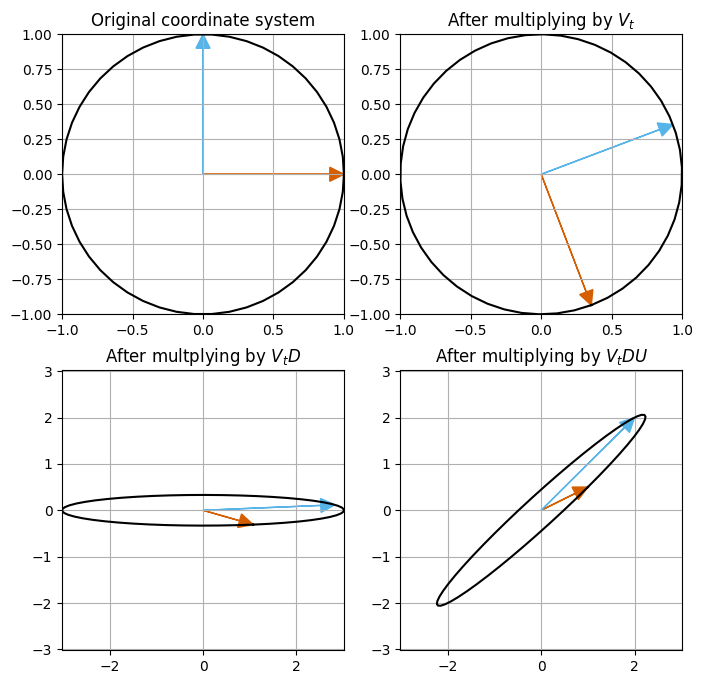

In [28]:
A1= np.array([[1.,  2],
             [ 0.5, 2.]])

U, D, V_t = our_SVD(A1)
no_points=50

angles = np.linspace(0, 2*np.pi, no_points+1)

x_coord = np.array([np.cos(angles)])
y_coord = np.array([np.sin(angles)])
vectors = np.concatenate((x_coord, y_coord), 0)

basis=np.array([[1,0],   # Apply to standard x and y unit vectors
                [0,1] ])


def plot(vectors, basis):
    plt.plot(vectors[0], vectors[1],color='black')
    mag = np.sqrt(vectors[0]**2 + vectors[1]**2)
    limit= np.max(mag)

    plt.arrow(0,0, basis[0,0], basis[1,0], length_includes_head=True, head_width=limit/10, head_length=limit/10, color='#D55E00')
    plt.arrow(0,0, basis[0,1], basis[1,1], length_includes_head=True, head_width=limit/10, head_length=limit/10, color='#56B4E9')
    plt.xlim([-limit, limit])
    plt.ylim([-limit, limit])
    plt.grid()
def vector_transform(mat, vectors, basis):
    new_vec= np.matmul(mat, vectors)
    new_basis=np.matmul(mat, basis)
    return (new_vec, new_basis)

plt.figure(figsize=[8, 8])
plt.axis()

plt.subplot(2,2,1)
plot(vectors, basis)
plt.title('Original coordinate system')

new_vec, new_basis = vector_transform(V_t, vectors, basis)
plt.subplot(2,2,2)
plot(new_vec, new_basis)
plt.title('After multiplying by $V_t$')

new_vec, new_basis = vector_transform(D, new_vec, new_basis)
plt.subplot(2,2,3)
plot(new_vec, new_basis)
plt.title('After multplying by $V_t D$')

new_vec, new_basis = vector_transform(U, new_vec, new_basis)
plt.subplot(2,2,4)
plot(new_vec, new_basis)
plt.title('After multiplying by $V_t D U$')

plt.show()

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# PCA, and its relation to SVD [^^](#appendix) <a id='pca_app'></a>
    
[Return to PCA section of notes](#pca_description)
    
## A note on columns and rows convention
    
Typically, vectors are represented as column vectors, which we shall continue in this proof. However, in Python it is easier to access rows of data than columns. Therefore data instances stored in A (which are vectors in n-dimensional space) are stored as **rows**, not columns. This explanation will highlight where this difference in convention poses an issue.

## Covariance Matrix

Let us consider the covariance matrix, $S$, a symmetric matrix with eigenvalues labelled by $\lambda_i$. Note for a real column vector: $\mathbf {x^Tx = x\cdot x }= \sum_{i} x^{(i)^2}$, where $x^{(i)}$ denotes the $i$-th feature of the vector $\mathbf{x}$. 
    
The elements of this matrix, $S_{ij}$, represent how correlated the two features $i$ and $j$ are. This is given by the following equation (where $x_{i}^{(m)}$ refers to the $m^{th}$ element of the vector $\mathbf x_{i}$):

\begin{equation} 
S_{ij} = \frac{1}{n-1} \mathbf{(x_i-\boldsymbol\mu_{i})^T(x_j-\boldsymbol\mu_{j})} = \frac{1}{n-1}\sum_{m=1}^n (x_{i}^{(m)}-\mu_{i})(x_{j}^{(m)}-\mu_{j})
\end{equation} 
    
On the major diagonal (with $n$ data instances) this gives:
  
\begin{equation}  
    S_{ii} = \frac{1}{n-1}(x_i-\mu_i)^T(x_i-\mu_i) = \frac{1}{n-1}\sum_{m=1}^{n} (x_{i}^{(m)}-\mu_i)^2
\end{equation}

This is the **variance** of the feature $i$.   
    


<div style="background-color:#efdff2">

### Finding the Projected Variance

We know that our data in $A$ is centred (the mean has been subtracted), so we can simplify our expression for $S$ using $A$:

\begin{equation}  
    S = \frac{1}{n-1} A^TA
\end{equation}
    
To project a column vector **y** onto a given axis $\mathbf{v}_1$, we perform $\mathbf{v_1}\cdot\mathbf{y}$, which in matrix notation is $\mathbf{v_1^Ty}$.  We note that out data instances are stored in A as **row vectors**; to transform these to column vectors we must use the transpose. $\mathbf{v_1^TA^T}$ will then give a **row vector** of the lengths of projection so our expression for the dot product will be reversed.
      
We can therefore find the **variance** of our data along this axis using the dot product (for simplicity, we now assume the data is centered):
    
\begin{align*}    
    Var^{projected} &= \frac{1}{n-1} (\mathbf{v_1^T} A^T) (\mathbf{v_1^T} A^T)^T \\
     &= \frac{1}{n-1} (\mathbf{v_1^T} A^T A \mathbf{v_1})  \\
     &= \mathbf{v_1^T} S \mathbf{v_1}
\end{align*}
    
This is the value we want to maximise, that is we say that $\mathbf{v}_1S\mathbf{v}_1$ is the projection of the variance along the principle component $\mathbf{v}_1$.

<div style="background-color:#efdff2">

### Lagrange Multipliers

As well as having a value we want to maximise, we also have the constraint that $\mathbf{v}$ should be a unit vector. Therefore $\mathbf{v}^T\mathbf{v}$ = 1, and our Lagrange multiplier equation is:
   
\begin{equation}     
    \mathcal{L}(\mathbf{v}, \lambda) = \mathbf{v^T} S \mathbf{v} - \lambda(\mathbf{v^Tv} -1)
\end{equation} 
    
We want $\mathcal{L}$ to be a maximum wrt $\mathbf{v}$. We will use the following identity for generic vectors $\mathbf{u}(\mathbf{x})$ and $\mathbf{v}(\mathbf{x})$, and a matrix $M$ that is not dependent on $\mathbf{x}$:

\begin{equation*}
\frac{\partial(\mathbf{u}^T M \mathbf{v})}{\partial\mathbf{v}} = \mathbf{u}^T M \frac{\partial\mathbf{v}}{\partial\mathbf{x}} + \mathbf{v}^T M^T \frac{\partial \mathbf{u}}{\partial \mathbf{x}}
\end{equation*}

For a symmetric matrix $M$ and $\mathbf{u} = \mathbf{v} = \mathbf{x}$, this reduces to:

\begin{align*}
\frac{\partial(\mathbf{x}^T M \mathbf{x})}{\partial\mathbf{x}} &= \mathbf{x}^T M + \mathbf{x}^T M^T \\
&= 2\mathbf{x}^T M
\end{align*}
where we have used that for symmetric $M$, $M^T = M$. 

    
We can use this result when trying to maximise the projected variance, as $S$ is symmetric:
      
\begin{equation}   
    \frac{d \mathcal{L}}{d \mathbf{v}} = 2 \mathbf{v^T} S - 2\lambda \mathbf{v^T} = 0 \\
\end{equation}
    
By rearranging and taking the transpose of both sides, we will obtain the eigenvalue equation for $S$:
\begin{equation}     
S \mathbf{v} = \lambda \mathbf{v}
\end{equation}  
    
We can combine this with our equation for the projected variance:
    
\begin{equation}
Var^{projected} =  \mathbf{v^T} S \mathbf{v} = \lambda \mathbf{v^T} \mathbf{v} = \lambda
\end{equation}
    
These two equations give us our key results:
    
**The vector on which projected data has maximum variance is an eigenvector of the covariance matrix.**
    
**The variance is the eigenvalue of that eigenvector.** 
    


  

<div style="background-color:#efdff2">

### Connection with SVD

We return to our equation 

\begin{equation}  
    S = \frac{1}{n-1} A^TA
\end{equation}
    
    
The eigenvectors for $A^TA$ are stored in $V$, and the eigenvalues stored in $D$. By equating the eigenvalues from both sides of this equation, we can find an expression for $\lambda_i$ and thus the projected variance:
\begin{equation}  
    Var^i = \frac{\sigma_i^2}{n-1} 
\end{equation}

The values of $\sigma$ are positive, and so arranging the eigenvectors by decreasing eigenvalues will also arrange them by decreasing variance. The vectors stored in $V$ are thus our required projection vectors. Our principle components are the eigenvectors that we find from our data, and we choose them in order of decreasing variance i.e. first principle component is the eigenvector with the largest eigenvalue, etc. 